# <center>Census Income Project</center><br>

# Problem Statement<br>
This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year. <br> 

Description of fnlwgt (final weight)<br>
The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

A single cell estimate of the population 16+ for each state.

Controls for Hispanic Origin by age and sex.

Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import LabelEncoder

In [2]:
census_data = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv")
census_data.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [3]:
census_data.tail()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32559,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [4]:
census_data.shape

(32560, 15)

In [5]:
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


We have 32560 observations and 15 columns, dataset has mix of data types.

In [6]:
# Checking missing value
census_data.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

There is no missing values in the dataset as we can see

# EDA 

In [7]:
census_data.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Age is right skewed and it has outlier, education is almost normal distrobuted, capital gian and capital loss are not giving clear picture we need to check as there is no min, 25th, median and 75th values values , Houer_per_week is slightly right skewed and has outlier. we will check all these in details further and treat the outlier as well. 

In [8]:
categorical_col = census_data.select_dtypes(include ="object")
categorical_col.describe()

,Workclass,Education,Marital_status,Occupation,Relationship,Race,Sex,Native_country,Income
count,32560,32560,32560,32560,32560,32560,32560,32560,32560
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27815,21789,29169,24719


Private job people count is high, data has most HS Grad people and white people count is high. We see 42 native countries but united state data has more frequency.
<=50K is more than >50K.


# EDA

In [9]:
# Creating a method for checking the distribution of the data and outlier
def create_plot(df,variable):
    
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    sns.distplot(df[variable])
    plt.title(Variable,"Distribution")
    
    plt.subplot(122)
    sns.boxplot(df[variable])
    plt.title(Variable,"Distribution")
    plt.show();

In [10]:
# Creating a method for checking the distribution of the data and outlier
def create_plot(df,variable):
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    sns.distplot(df[variable], color='Blue')

    
    plt.subplot(122)
    sns.boxplot(df[variable], color='Blue')
    plt.show();

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


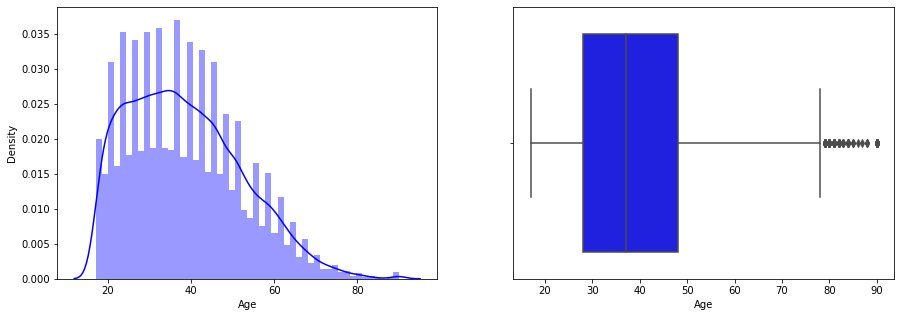

In [11]:
create_plot(census_data, "Age")

Age is right skewed data and we see that there are some outlier in the column 

In [12]:
def check_value(x):
    for i in x.columns:
        print(x[i].value_counts(),"\n")
        

In [13]:
check_value(categorical_col)

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64 

 HS-grad         10501
 Some-college     7291
 Bachelors        5354
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: Education, dtype: int64 

 Married-civ-spouse       14976
 Never-married            10682
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital_status, dtype: int64 

 Prof-specialty       4140
 Craft-repair         4099
 Exec-mana

we have ? mark in the columns which is a sort of missing val, it wasnt got identify during the missing value analysis. let replace them with Nan value and impute them from the columns like Workclass,Occupation and Native_country

In [14]:
testing_data = census_data.copy()

In [15]:
testing_data.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

In [16]:
# replaceing ? with nan value
testing_data["Workclass"] = testing_data["Workclass"].str.strip().replace({"?" : np.nan})
testing_data["Occupation"] = testing_data["Occupation"].str.strip().replace({"?" : np.nan})
testing_data["Native_country"] = testing_data["Native_country"].str.strip().replace({"?" : np.nan})

have tried replacing ? with nan in a simple way but have seen that it wasnt getting converting then thought of appying strip to remove any space and then try and it worked. ? replaced with missing value. now then impute them

In [17]:
testing_data.isnull().sum()

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     583
Income               0
dtype: int64

In [18]:
testing_data.groupby("Workclass")["Age"].mean()

Workclass
Federal-gov         42.590625
Local-gov           41.751075
Never-worked        20.571429
Private             36.797585
Self-emp-inc        46.017025
Self-emp-not-inc    44.969697
State-gov           39.436392
Without-pay         47.785714
Name: Age, dtype: float64

We see that below or equal to 20 come under never work category because of they are student. Without pay are older in the age column. we will impute the work place accord 

In [19]:
testing_data.groupby(["Occupation","Workclass"])["Occupation"].count()

Occupation        Workclass       
Adm-clerical      Federal-gov          317
                  Local-gov            283
                  Private             2833
                  Self-emp-inc          31
                  Self-emp-not-inc      50
                                      ... 
Transport-moving  Private             1266
                  Self-emp-inc          27
                  Self-emp-not-inc     122
                  State-gov             41
                  Without-pay            1
Name: Occupation, Length: 81, dtype: int64

have checked workclass as per occupation but no significant pattern found to impute workplace, let see its match with target columns can it be help for imputing

In [20]:
testing_data.groupby("Workclass")["Income"].count()

Workclass
Federal-gov           960
Local-gov            2093
Never-worked            7
Private             22696
Self-emp-inc         1116
Self-emp-not-inc     2541
State-gov            1297
Without-pay            14
Name: Income, dtype: int64

with income we cannot impute them.

In [21]:
bins = [0,10,20,30,40,50,60,70,80,90]
testing_data["Age_bins"] = pd.cut(testing_data["Age"],bins = bins)

In [22]:
pd.set_option("display.max_rows", None)
testing_data.groupby(["Age_bins","Workclass"])["Workclass"].count()

Age_bins  Workclass       
(0, 10]   Federal-gov            0
          Local-gov              0
          Never-worked           0
          Private                0
          Self-emp-inc           0
          Self-emp-not-inc       0
          State-gov              0
          Without-pay            0
(10, 20]  Federal-gov           18
          Local-gov             47
          Never-worked           5
          Private             1834
          Self-emp-inc          19
          Self-emp-not-inc      48
          State-gov             53
          Without-pay            2
(20, 30]  Federal-gov          139
          Local-gov            383
          Never-worked           2
          Private             6503
          Self-emp-inc         102
          Self-emp-not-inc     304
          State-gov            294
          Without-pay            3
(30, 40]  Federal-gov          258
          Local-gov            540
          Never-worked           0
          Private           

we see that all the workclass are present in all the age bucket.so impute them with age mean in better. we are going to impute them.

In [23]:
def impute_workclass(x):
    workclass = x[0]
    age = x[1]
    
    if pd.isnull(workclass):
        if age < 20.571429:
            return "Never-worked"
        elif age >20.571429  and age <= 36.797585:
            return "Private"
        elif age >36.797585  and age <= 39.436392:
            return "State-gov"
        elif age >39.436392  and age <= 41.751075:
            return "Local-gov"
        elif age >41.751075 and age <=42.590625:
            return  "Federal-gov"
        elif age > 42.590625 and age <=44.969697:
            return "Self-emp-not-inc"
        elif age > 44.969697 and age <= 46.017025:
            return "Self-emp-inc"
        elif age > 46.017025:
            return "Without-pay"
    else:
        return workclass

In [24]:
testing_data["Workclass"] =testing_data[["Workclass","Age"]].apply(impute_workclass,axis =1)

In [25]:
testing_data.isnull().sum()

Age                  0
Workclass            0
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     583
Income               0
Age_bins             0
dtype: int64

In [26]:
testing_data.groupby("Occupation")["Age"].mean()

Occupation
Adm-clerical         36.963916
Armed-Forces         30.222222
Craft-repair         39.031471
Exec-managerial      42.169208
Farming-fishing      41.211268
Handlers-cleaners    32.165693
Machine-op-inspct    37.715285
Other-service        34.949621
Priv-house-serv      41.724832
Prof-specialty       40.517633
Protective-serv      38.953775
Sales                37.353973
Tech-support         37.022629
Transport-moving     40.197871
Name: Age, dtype: float64

Average age of all the occupations are very close and  we will impute it with mode

In [27]:
testing_data["Occupation"] = testing_data["Occupation"].fillna(testing_data["Occupation"].mode()[0]) 

In [28]:
testing_data.isnull().sum()

Age                 0
Workclass           0
Fnlwgt              0
Education           0
Education_num       0
Marital_status      0
Occupation          0
Relationship        0
Race                0
Sex                 0
Capital_gain        0
Capital_loss        0
Hours_per_week      0
Native_country    583
Income              0
Age_bins            0
dtype: int64

In [29]:
testing_data["Native_country"].value_counts()

United-States                 29169
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

In [30]:
# imputing native country with mode
testing_data["Native_country"] = testing_data["Native_country"].fillna(testing_data["Native_country"].mode()[0]) 


In [31]:
testing_data.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
Age_bins          0
dtype: int64

**Data is now clean in terms of missing value, we have imputed all of them.**

In [32]:
# Delete age_bins
testing_data.drop("Age_bins",axis =1 , inplace = True)

In [33]:
# lets check the numerical columsn distribution and outlier
num_col = testing_data.select_dtypes(exclude = "object" )

In [34]:
num_col.columns

Index(['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss',
       'Hours_per_week'],
      dtype='object')

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


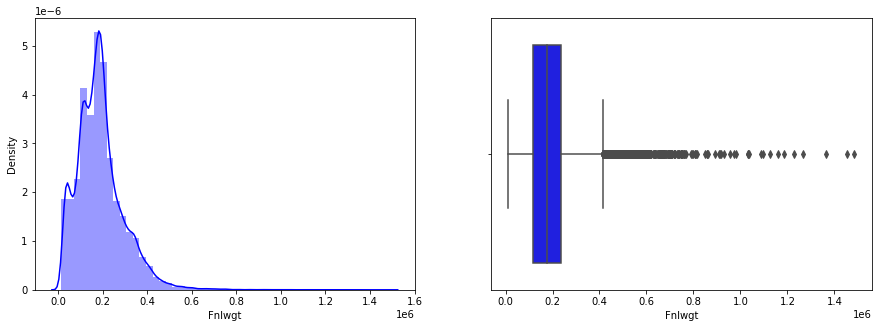

In [35]:
create_plot(num_col,"Fnlwgt")

have lot of outlier values and it is right skewed 

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


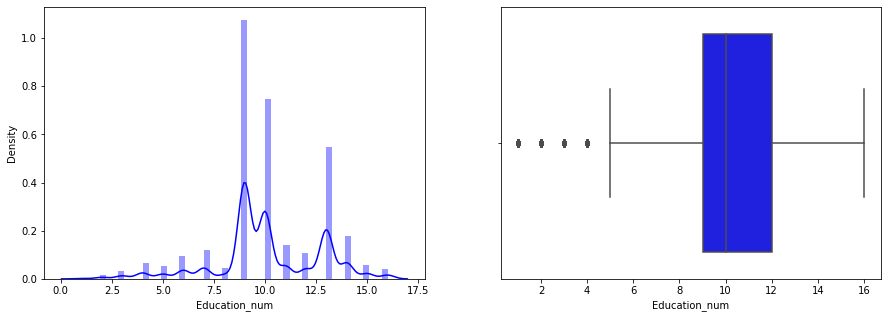

In [36]:
create_plot(num_col,"Education_num")

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


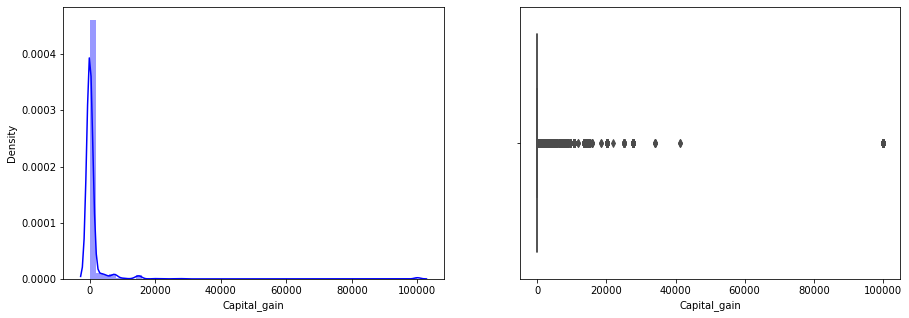

In [37]:
create_plot(num_col,"Capital_gain")

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


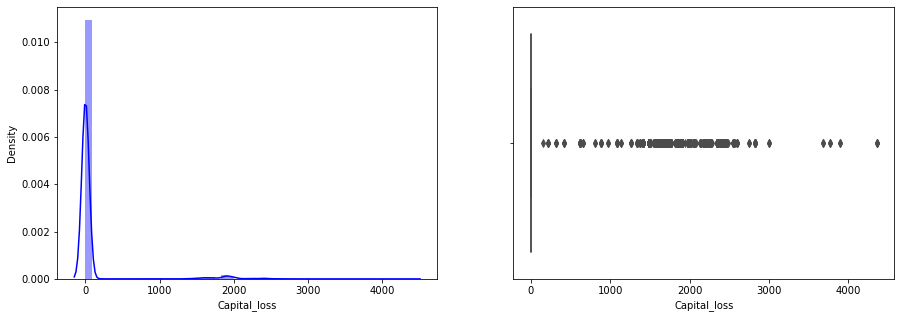

In [38]:
create_plot(num_col,"Capital_loss")

capital loss and gain have lot of outlier values lets check and try to corect them.

In [39]:
# Let replace target column with 0 and 1. 0  will be <=50K and 1 will be >50

testing_data["Income"] = testing_data["Income"].str.strip().replace({">50K" :1, "<=50K" :0})

In [40]:
testing_data.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Income', ylabel='count'>

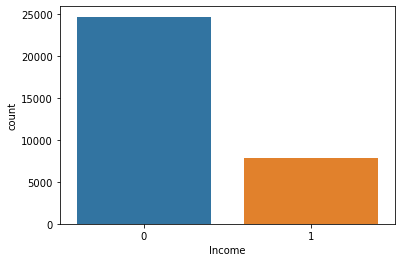

In [41]:
sns.countplot(testing_data["Income"])

<=50K is higher than >50K, it is imbalance dataset we will treat them later on.

In [42]:
testing_data["temp_income"] = census_data["Income"]

In [43]:
# lets do some analysis for insight
pd.pivot_table(testing_data, values = "Income", index = ["temp_income","Workclass"], aggfunc = "count")

Income
temp_income Workclass               
 <=50K      Federal-gov          603
            Local-gov           1507
            Never-worked         390
            Private            18289
            Self-emp-inc         514
            Self-emp-not-inc    1837
            State-gov            978
            Without-pay          601
 >50K       Federal-gov          372
            Local-gov            621
            Never-worked           1
            Private             4990
            Self-emp-inc         624
            Self-emp-not-inc     727
            State-gov            357
            Without-pay          149

As we have inbalance class variable, we can see clearly that number of instances workclass wise are more  in <=50K

In [44]:
pd.pivot_table(testing_data, values = "Income", index = "Native_country", aggfunc = "count", columns ="temp_income")

temp_income,<=50K,>50K
Native_country,,
Cambodia,12.0,7.0
Canada,82.0,39.0
China,55.0,20.0
Columbia,57.0,2.0
Cuba,70.0,25.0
Dominican-Republic,68.0,2.0
Ecuador,24.0,4.0
El-Salvador,97.0,9.0
England,60.0,30.0


91% data belongs to United state nation and rest  9 % are other conuntries. so we are combining them into US(1) and NON_US(0)

In [45]:
d = {'Dominican-Republic': 0,'Cuba': 0,'Canada': 0,'Yugoslavia': 0,'Puerto-Rico': 0,'Japan': 0,'Greece': 0,'France': 0,'Iran': 0,'Thailand': 0,'Hungary': 0,
'England': 0,'Outlying-US(Guam-USVI-etc)': 0,'Nicaragua': 0,'Italy': 0,'Honduras': 0,'Mexico': 0,'Ecuador': 0,'Haiti': 0,'Portugal': 0,'Holand-Netherlands': 0,
'Columbia': 0,'Philippines': 0,'Poland': 0,'Hong': 0,'China': 0,'Laos': 0,'Scotland': 0,'El-Salvador': 0,'Taiwan': 0,'Germany': 0,'Vietnam': 0,
'Jamaica': 0,'Trinadad&Tobago': 0,'India': 0,'Peru': 0,'South': 0,'Guatemala': 0,'Ireland': 0,'Cambodia': 0}

In [46]:
testing_data["Native_country"] = testing_data["Native_country"].replace({"United-States":1})

In [47]:
testing_data["Native_country"] = testing_data["Native_country"].replace(d)

In [48]:
testing_data.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income,temp_income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,1,0,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,1,0,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,1,0,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,0,0,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,1,0,<=50K


In [49]:
categorical_col.columns

Index(['Workclass', 'Education', 'Marital_status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Native_country', 'Income'],
      dtype='object')

In [50]:
pd.pivot_table(testing_data, values ="Income", index = ["Sex","Education_num"], columns = "temp_income", aggfunc ="count")

temp_income             <=50K    >50K
Sex     Education_num                
 Female 1                16.0     NaN
        2                46.0     NaN
        3                82.0     2.0
        4               159.0     1.0
        5               139.0     5.0
        6               292.0     3.0
        7               424.0     8.0
        8               140.0     4.0
        9              3164.0   226.0
        10             2609.0   197.0
        11              433.0    67.0
        12              365.0    56.0
        13             1280.0   339.0
        14              357.0   179.0
        15               50.0    42.0
        16               36.0    50.0
 Male   1                35.0     NaN
        2               116.0     6.0
        3               235.0    14.0
        4               447.0    39.0
        5               348.0    22.0
        6               579.0    59.0
        7               691.0    52.0
        8               260.0    29.0
        9              5662.0  1449.0
        10             3295.0  1190.0
        11              588.0   294.0
        12              437.0   209.0
        13             1853.0  1882.0
        14              407.0   780.0
        15              103.0   381.0
        16               71.0   256.0

Male frquency is more in the dataset and we see that higher count if for more. we can also see that as education year increase the number of <50K or >50K also increase

In [51]:
pd.pivot_table(testing_data, values ="Income", index = ["Sex"], columns = "temp_income", aggfunc ="count")

temp_income,<=50K,>50K
Sex,,
Female,9592,1179
Male,15127,6662


we alread talk about it that male freqeucny is more in the dataset 

In [52]:
pd.pivot_table(testing_data, values ="Age", index = ["Sex"], aggfunc ="mean")

,Age
Sex,
Female,36.858230
Male,39.433567


In [53]:
pd.pivot_table(testing_data, values ="Income", index = ["Sex","Workclass"], aggfunc ="count", columns = "temp_income")

temp_income                 <=50K    >50K
Sex     Workclass                        
 Female Federal-gov         262.0    57.0
        Local-gov           703.0   156.0
        Never-worked        209.0     1.0
        Private            7327.0   746.0
        Self-emp-inc        104.0    43.0
        Self-emp-not-inc    326.0    84.0
        State-gov           442.0    71.0
        Without-pay         219.0    21.0
 Male   Federal-gov         341.0   315.0
        Local-gov           804.0   465.0
        Never-worked        181.0     NaN
        Private           10962.0  4244.0
        Self-emp-inc        410.0   581.0
        Self-emp-not-inc   1511.0   643.0
        State-gov           536.0   286.0
        Without-pay         382.0   128.0

Both the gender are working in all the category, male average age is greater than female

In [54]:
pd.pivot_table(testing_data, values ="Income", index = ["Race","Sex"], aggfunc ="count", columns = "temp_income")

temp_income                   <=50K   >50K
Race                Sex                   
 Amer-Indian-Eskimo  Female     107     12
                     Male       168     24
 Asian-Pac-Islander  Female     303     43
                     Male       460    233
 Black               Female    1465     90
                     Male      1272    297
 Other               Female     103      6
                     Male       143     19
 White               Female    7614   1028
                     Male     13084   6089

Other than white survay ratio is  almost equal, white people participated more in survay  

In [55]:
pd.pivot_table(testing_data, values ="Education_num", index = ["Education"], aggfunc ="count", columns = "temp_income")

temp_income,<=50K,>50K
Education,,
10th,871.0,62.0
11th,1115.0,60.0
12th,400.0,33.0
1st-4th,162.0,6.0
5th-6th,317.0,16.0
7th-8th,606.0,40.0
9th,487.0,27.0
Assoc-acdm,802.0,265.0
Assoc-voc,1021.0,361.0


Hs grade and some-collage educated people earning count is more than other education category.

In [56]:
pd.pivot_table(testing_data, values ="Income", index = ["Marital_status"], aggfunc ="count", columns = "temp_income")

temp_income,<=50K,>50K
Marital_status,,
Divorced,3980,463
Married-AF-spouse,13,10
Married-civ-spouse,8284,6692
Married-spouse-absent,384,34
Never-married,10191,491
Separated,959,66
Widowed,908,85


under category <=50K never married people count is high however married with Civilian are earning more in <=50K and > 50K category

#  Outlier treatment
**With capping with upper and lower bound**

In [57]:
def outlier_imoute_with_IQR(x, variable):
    q1 = x[variable].quantile(.25)
    q3 = x[variable].quantile(.75)
    IQR = q3-q1

    upper_bound = q3 + (1.5*IQR)
    lower_bound = q1 - (1.5*IQR)
    
    x[variable] = np.where(x[variable] > upper_bound,upper_bound, np.where(x[variable] < lower_bound, lower_bound , x[variable]))


In [58]:
def outlier_imoute_with_Mean_std(x, variable):
    Mean = x[variable].mean()
    STD = x[variable].std()
    
    lower_bound = Mean - (3*STD)
    upper_bound = Mean + (3*STD)
    
    x[variable] = np.where(x[variable] > upper_bound,upper_bound, np.where(x[variable] < lower_bound, lower_bound , x[variable]))

In [59]:
outlier_imoute_with_IQR(testing_data,"Age")
outlier_imoute_with_IQR(testing_data,"Education_num")
outlier_imoute_with_Mean_std(testing_data,"Capital_gain")
outlier_imoute_with_Mean_std(testing_data,"Capital_loss")
outlier_imoute_with_IQR(testing_data,"Hours_per_week")

1. Age, Education_num,  and Hours_per_weeks' outlier capped by IQR methoed<br>
2. Capital_gain and loss are capped by 3rd standard deviation method<br><br>

Have applied IQR methoed to cap the outlier in Capital_gain and loss but all value came to 0 so we have done  it by using the  mean and standard deviation. 

In [60]:
testing_data.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income,temp_income
0,50.0,Self-emp-not-inc,83311,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,32.5,1,0,<=50K
1,38.0,Private,215646,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,1,0,<=50K
2,53.0,Private,234721,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,1,0,<=50K
3,28.0,Private,338409,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,0,0,<=50K
4,37.0,Private,284582,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,1,0,<=50K


In [61]:
# we will drop temp_income it was created temporary for analysis purpose
testing_data.drop("temp_income",axis= 1,inplace= True)

# Label Encoding

In [62]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

testing_data["Workclass"] = le.fit_transform(testing_data["Workclass"])
testing_data["Education"] = le.fit_transform(testing_data["Education"])
testing_data["Marital_status"] = le.fit_transform(testing_data["Marital_status"])
testing_data["Occupation"] = le.fit_transform(testing_data["Occupation"])
testing_data["Relationship"] = le.fit_transform(testing_data["Relationship"])
testing_data["Race"] = le.fit_transform(testing_data["Race"])
testing_data["Sex"] = le.fit_transform(testing_data["Sex"])

In [63]:
testing_data.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50.0,5,83311,9,13.0,2,3,0,4,1,0.0,0.0,32.5,1,0
1,38.0,3,215646,11,9.0,0,5,1,4,1,0.0,0.0,40.0,1,0
2,53.0,3,234721,1,7.0,2,5,0,2,1,0.0,0.0,40.0,1,0
3,28.0,3,338409,9,13.0,2,9,5,2,0,0.0,0.0,40.0,0,0
4,37.0,3,284582,12,14.0,2,3,5,4,0,0.0,0.0,40.0,1,0


All the categorical columns have been encoded

<AxesSubplot:>

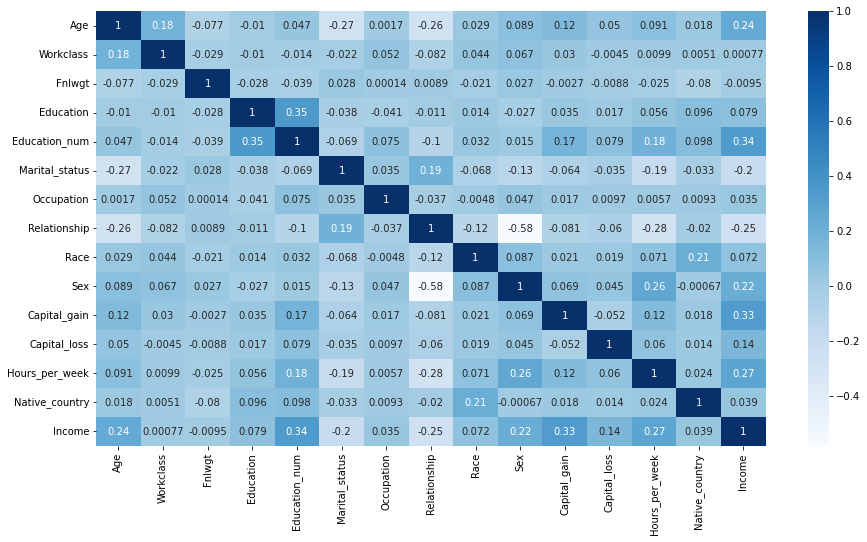

In [64]:
plt.figure(figsize = (15,8))
sns.heatmap(testing_data.corr(),annot = True,cmap="Blues")

We will drop the fnlwgt as it sample weight which is assign to the data and it is also not contributing to target variable.

In [65]:
testing_data.drop("Fnlwgt",axis = 1, inplace = True)

In [66]:
# copying clearn data into original file
Censun_data = testing_data.copy()

# Scalling the features

In [67]:
sc = StandardScaler()

X = sc.fit_transform(testing_data.drop("Income",axis =1))
y = testing_data["Income"]

# Handling imbalance dataset

In [68]:
smote = SMOTETomek(random_state=45)
resam_X,resam_y = smote.fit_resample(X,y)

# Modeling

In [69]:


for i in range(50,300,60):
    X_train,X_test,y_train,y_test = train_test_split(resam_X,resam_y,test_size = 0.3, random_state = i)
    LR = LogisticRegression()
    LR.fit(X_train,y_train)
    pred = LR.predict(X_test)
    print("Accuracy_score", accuracy_score(y_test,pred),"Random_state",i)
    print("Confusion_matrix ","\n", confusion_matrix(y_test,pred))
    print("classification_report", "\n", classification_report(y_test,pred))
    


Accuracy_score 0.7792369366878629 Random_state 50
Confusion_matrix  
 [[5600 1592]
 [1602 5674]]
classification_report 
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      7192
           1       0.78      0.78      0.78      7276

    accuracy                           0.78     14468
   macro avg       0.78      0.78      0.78     14468
weighted avg       0.78      0.78      0.78     14468

Accuracy_score 0.7773016311860658 Random_state 110
Confusion_matrix  
 [[5615 1595]
 [1627 5631]]
classification_report 
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      7210
           1       0.78      0.78      0.78      7258

    accuracy                           0.78     14468
   macro avg       0.78      0.78      0.78     14468
weighted avg       0.78      0.78      0.78     14468

Accuracy_score 0.7819325407796517 Random_state 170
Confusion_matrix  
 [[5584 1590]
 [1565 5729]]
class

In [70]:
model = [RandomForestClassifier(), SVC(),GaussianNB()]
for i in model:
    X_train1,X_test1,y_train1,y_test1 = train_test_split(resam_X,resam_y,test_size = 0.3, random_state = 290)
    i.fit(X_train1,y_train1)
    pred = i.predict(X_test1)
    print("Accuracy_score", accuracy_score(y_test1,pred),i)
    print("Confusion_matrix ","\n", confusion_matrix(y_test1,pred))
    print("classification_report", "\n", classification_report(y_test1,pred))

Accuracy_score 0.8970141000829417 RandomForestClassifier()
Confusion_matrix  
 [[6477  748]
 [ 742 6501]]
classification_report 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      7225
           1       0.90      0.90      0.90      7243

    accuracy                           0.90     14468
   macro avg       0.90      0.90      0.90     14468
weighted avg       0.90      0.90      0.90     14468

Accuracy_score 0.8460049764998617 SVC()
Confusion_matrix  
 [[5749 1476]
 [ 752 6491]]
classification_report 
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      7225
           1       0.81      0.90      0.85      7243

    accuracy                           0.85     14468
   macro avg       0.85      0.85      0.85     14468
weighted avg       0.85      0.85      0.85     14468

Accuracy_score 0.7665192148189107 GaussianNB()
Confusion_matrix  
 [[6365  860]
 [2518 4725]]
classificat

Have checked the accuracy score with both dataset balance and imbalace dataset, accuracy score was less in imbalance dataset and f1 score wasnt good or less class. 

In [71]:
RF  = RandomForestClassifier()
parameter = {"n_estimators":[100,200,300],
            "criterion" : ["gini", "entropy"],
            "max_depth":[2,3,4,5],
            "max_features" : ["auto", "sqrt", "log2"]}

grid_score = RandomizedSearchCV(RF,parameter,scoring = "f1",cv = 5,verbose = 2, n_jobs=-1,random_state = 1)
grid_score.fit(X_train1,y_train1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 200, 300]},
                   random_state=1, scoring='f1', verbose=2)

In [72]:
print(grid_score.best_params_)

{'n_estimators': 100, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini'}


In [73]:
cross_RF = RandomForestClassifier(n_estimators= 300, max_features = 'sqrt', max_depth = 5, criterion = 'gini',random_state=1)
for i in range(2,10):
    cross_score = cross_val_score(cross_RF,resam_X,resam_y,cv =i,scoring = "f1", n_jobs =-1)
    print( i,"mean_score",cross_score.mean(),"STD score",cross_score.std() )

2 mean_score 0.8439863220734143 STD score 0.005090174470769482
3 mean_score 0.8447351216534319 STD score 0.007216256089244019
4 mean_score 0.8447850296307947 STD score 0.007669172089804178
5 mean_score 0.8431699095132551 STD score 0.008188620811606465
6 mean_score 0.8447075511221347 STD score 0.007797187560253499
7 mean_score 0.8443761570903049 STD score 0.008188911343834829
8 mean_score 0.8453233888082643 STD score 0.008177536975034675
9 mean_score 0.8448922161951975 STD score 0.008716631230801776


so finally we have come to the end of the projects, we selected Randomforest as final modela nd performed RandomserachCV and Cross_cal score, we have got best parameter for after Random search and then model is trained with cross_cal_score, we seen that CV 9 is giving best mean and std deviation.

# Model Saving

In [74]:
Best_RF = RandomForestClassifier(n_estimators= 200, max_features = 'sqrt', max_depth = 5, criterion = 'entropy')
Best_RF.fit(resam_X,resam_y)
import pickle
file_name = "Census.pkl"
with open(file_name,"wb") as f:
    pickle.dump(Best_RF,f)

# Conclusion<br>
we had mix of columns like numeric and object type. Have checked numeric columns except capital_loss and again, other columns were having min and other percentile score. we saw outlier also in these numeric columns. Outlier handled with IQR and 3rd stanard deviation.<br><br>
we have done important analysis on categorical features with taregt variable and found certain interest facts like Workclass Private job people earning is high, from Sex columns we observed that male and female both are working in all the department/sector. Maximum people native country is United state thus we seen high earning for united state than other countries.we also observed that HS grad and some-collage are earning high from education columns.all categorical columns are Label Encoded<br><br>

As we seen that target class was imbalance data set, it was bent to one side which was <=50K. imbalance problem was handled by up sampling with SMOTE algorithm.Model was trained on both the dataset, i got high accuracy with upsample data, thus have considered the same.<br>I have used 4 models on the dataset to check which one is working well, Randomforest has raisen as best out of them so i have used that for final model.post selection of the algorithm i have performed RandomizedSearchCV and cross_val_score. 
Final i have saved the model with pickle extension with Randomforest model.